In [1]:
library(tidyverse)
library(data.table)
library(lubridate)

df <- fread("/kaggle/input/online-retail-ii-uci/online_retail_II.csv")

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     


── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors



Attaching package: ‘data.table’




The following objects are masked from ‘package:lubridate’:

    hour, isoweek, mday, minute, month, quarter, second, wday, week,
    yday, year




The following objects are masked from ‘package:dplyr’:

    between, first, last




The following object is masked from ‘package:purrr’:

    transpose




In [2]:
df <- df %>%
  filter(!is.na(`Customer ID`)) %>% 
  mutate(
    InvoiceDate = as.Date(InvoiceDate),
    TotalPrice = Quantity * Price,
    CustomerID = as.character(`Customer ID`)
  )

In [3]:
analysis_date <- max(df$InvoiceDate) + 1

rfm <- df %>%
  group_by(CustomerID) %>%
  summarise(
    Recency = as.numeric(analysis_date - max(InvoiceDate)),
    Frequency = n(),
    Monetary = sum(TotalPrice)
  )

In [4]:
rfm <- rfm %>%
  mutate(
    R_score = ntile(-Recency, 5),
    F_score = ntile(Frequency, 5),
    M_score = ntile(Monetary, 5),
    RFM_score = R_score + F_score + M_score
  )

In [5]:
rfm <- rfm %>%
  mutate(
    Segment = case_when(
      RFM_score >= 13 ~ "VIP",
      RFM_score >= 10 ~ "Loyal",
      RFM_score >= 7  ~ "Regular",
      RFM_score >= 4  ~ "At Risk",
      TRUE            ~ "Lost"
    )
  )
glimpse(rfm)

Rows: 5,942
Columns: 9
$ CustomerID <chr> "12346", "12347", "12348", "12349", "12350", "12351", "1235…
$ Recency    <dbl> 326, 3, 76, 19, 311, 376, 37, 205, 233, 215, 23, 34, 2, 8, …
$ Frequency  <int> 48, 253, 51, 180, 17, 21, 113, 24, 58, 35, 143, 296, 77, 37…
$ Monetary   <dbl> -64.68, 5633.32, 2019.40, 4404.54, 334.40, 300.93, 1889.21,…
$ R_score    <int> 2, 5, 3, 4, 2, 2, 4, 2, 2, 2, 4, 4, 5, 5, 4, 2, 5, 3, 5, 2,…
$ F_score    <int> 3, 5, 3, 4, 2, 2, 4, 2, 3, 2, 4, 5, 3, 5, 5, 2, 5, 2, 4, 2,…
$ M_score    <int> 1, 5, 4, 5, 2, 2, 4, 2, 3, 3, 5, 5, 5, 5, 5, 2, 5, 2, 4, 2,…
$ RFM_score  <int> 6, 15, 10, 13, 6, 6, 12, 6, 8, 7, 13, 14, 13, 15, 14, 6, 15…
$ Segment    <chr> "At Risk", "VIP", "Loyal", "VIP", "At Risk", "At Risk", "Lo…


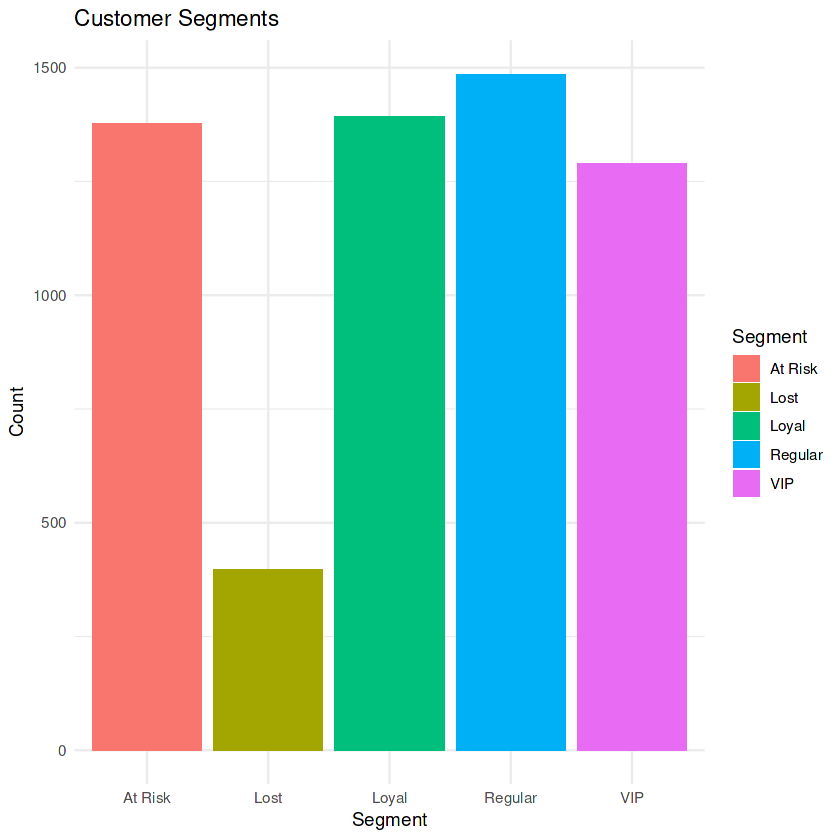

In [6]:
rfm %>%
  count(Segment) %>%
  ggplot(aes(x = Segment, y = n, fill = Segment)) +
  geom_col() +
  labs(title = "Customer Segments", x = "Segment", y = "Count") +
  theme_minimal()

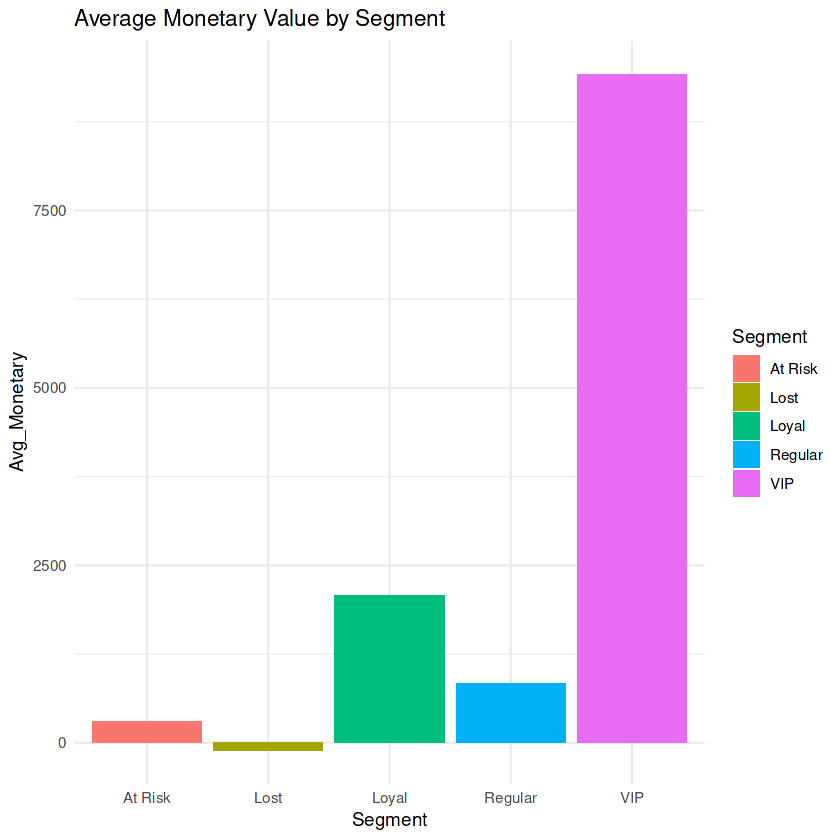

In [7]:
rfm %>%
  group_by(Segment) %>%
  summarise(Avg_Monetary = mean(Monetary)) %>%
  ggplot(aes(x = Segment, y = Avg_Monetary, fill = Segment)) +
  geom_col() +
  labs(title = "Average Monetary Value by Segment") +
  theme_minimal()

# Insight
- VIP customers generate the highest revenue and purchase frequently
- Loyal customers buy often but spend less than VIPs
- Regular customers show stable but moderate activity
- At Risk customers haven't purchased recently and need re‑engagement
- Lost customers have very low activity and long recency
# Conclusion
RFM segmentation provides a clear understanding of customer value and helps prioritize marketing strategies such as retention, reactivation, and loyalty programs